# Ценообразование автомобилей

**Задача** - построить модель для определения стоимости авто

**Ключевые шаги**  
1. Предобработка данных
2. Подготовка признаков
3. Построение моделей
4. Тестирование

**Описание**  
Сервис по продаже подержанных авто разрабатывает приложение, в котором можно быстро узнать рыночную стоимость автомобиля. Предоставлены исторические данные: технические характеристики, комплектации и цены. Необходимо построить модель для определения стоимости с учётом важности качества предсказания и скорости предсказания и обучения.

**Библиотеки**  
pandas, numpy, matplotlib, sklearn, catboost, lightgbm

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import pylab as pl
import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder

In [2]:
!pip install catboost
!pip install lightgbm

In [3]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [4]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('max_columns', None)

In [5]:
df = pd.read_csv('autos.csv')

## Обзор данных

In [6]:
df.columns = df.columns.str.lower()

In [7]:
df.shape

(354369, 16)

In [8]:
length = len(df)

In [9]:
df.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   kilometer          354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  notrepaired        283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

Категориальные переменные: VehicleType, RegistrationYear, Gearbox, Model, Kilometer, RegistrationMonth, FuelType, Brand, NotRepaired  
Количественные: Price, Power

In [11]:
df.isnull().sum().sort_values(ascending = False).head(5)

notrepaired    71154
vehicletype    37490
fueltype       32895
gearbox        19833
model          19705
dtype: int64

In [12]:
print('Количество уникальных значений каждой переменной \n')
for col in df.columns:
    print(col)
    print(len(df[col].unique()), '\n')

Количество уникальных значений каждой переменной 

datecrawled
271174 

price
3731 

vehicletype
9 

registrationyear
151 

gearbox
3 

power
712 

model
251 

kilometer
13 

registrationmonth
13 

fueltype
8 

brand
40 

notrepaired
3 

datecreated
109 

numberofpictures
1 

postalcode
8143 

lastseen
179150 



Нам предоставлены данные по техническим характеристикам автомобилей для продажи в Германии на основе разных почтовых зон.     
Целевой признак - стоимость машины, другие признаки представляют технические характеристики и комплектации.     
Всего в датафрейме 354'369 наблюдений, 16 переменных, 5 из которых содержат пропуски. 

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,354369.00,4416.66,4514.16,0.00,1050.00,2700.00,6400.00,20000.00
registrationyear,354369.00,2004.23,90.23,1000.00,1999.00,2003.00,2008.00,9999.00
power,354369.00,110.09,189.85,0.00,69.00,105.00,143.00,20000.00
kilometer,354369.00,128211.17,37905.34,5000.00,125000.00,150000.00,150000.00,150000.00
registrationmonth,354369.00,5.71,3.73,0.00,3.00,6.00,9.00,12.00
numberofpictures,354369.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
postalcode,354369.00,50508.69,25783.10,1067.00,30165.00,49413.00,71083.00,99998.00


In [14]:
df.describe(include = 'object').T

,count,unique,top,freq
datecrawled,354369,271174,2016-03-24 14:49:47,7
vehicletype,316879,8,sedan,91457
gearbox,334536,2,manual,268251
model,334664,250,golf,29232
fueltype,321474,7,petrol,216352
brand,354369,40,volkswagen,77013
notrepaired,283215,2,no,247161
datecreated,354369,109,2016-04-03 00:00:00,13719
lastseen,354369,179150,2016-04-06 13:45:54,17


В переменной кол-во фото отсутствуют значения. Заметны явные выбросы в переменной RegistrationYear, Price, Power.  

Портрет среднего автомобиля: цена = 4.5 тыс. евро, мощность = 110 л.с., пробег = 128 тыс. км, механическая коробка передач, тип кузова - седан, модель - фольксваген гольф

## Проверка дубликатов

In [15]:
df[df.duplicated(subset = df.columns.difference(['datecrawled', 'lastseen', 'datecreated'])) == True].shape[0]/length * 100

6.0199961057541715

Без учёта дат создания объявления, последней активности и выкачивания анкеты из базы, т.к. автовладелец мог дважды выложить одно объявление, необходимо оставить последнее выложенное с наиболее актуальной информацией

In [16]:
df = df.sort_values(by='datecreated')

In [17]:
df = df.drop_duplicates(subset = df.columns.difference(['datecrawled', 'lastseen', 'datecreated']), keep='last').reset_index(drop=True)

#### Обработка выбросов

In [18]:
numeric = ['price', 'power', 'kilometer', 'registrationyear']

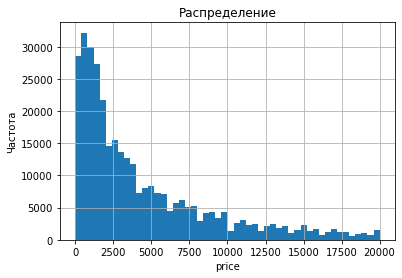

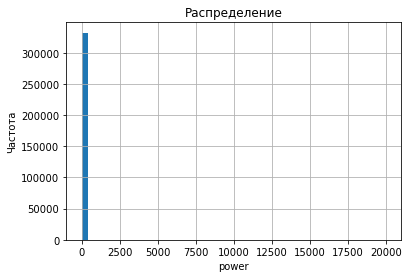

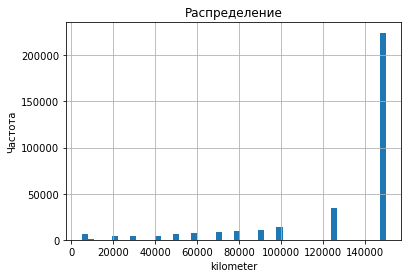

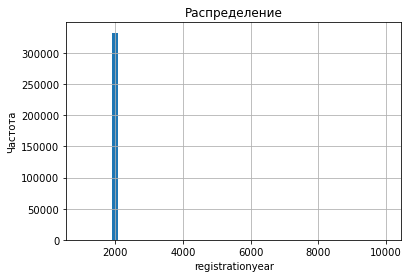

In [19]:
for col in df[numeric].columns:      
    df[col] = pd.to_numeric(df[col]) 
    h = df.hist(column=col, bins=50)
    pl.title('Распределение')
    for ax in h.flatten():
        ax.set_xlabel(col)
        ax.set_ylabel("Частота")

In [20]:
for col in df[numeric]:
    outliers_up = df[df[col] > df[col].quantile(0.75) + 1.5 * df[col].std()][col]
    outliers_down = df[df[col] < df[col].quantile(0.25) - 1.5 * df[col].std()][col]
    print(col, '\n {:.2%}'.format(len(outliers_up)/len(df)))
    print("{:.2%} \n".format(len(outliers_down)/len(df)))

price 
 6.91%
0.00% 

power 
 0.20%
0.00% 

kilometer 
 0.00%
9.70% 

registrationyear 
 0.03%
0.02% 



In [21]:
print('Часть данных с выбросом года регистрации {:.2%}'.
      format(len(df[(df['registrationyear']>2019) | (df['registrationyear']<=1900)])/len(df)))

Часть данных с выбросом года регистрации 0.05%


In [22]:
df = df[(df['registrationyear']<2020) & (df['registrationyear']>1900)].reset_index(drop=True)

Ограничим мощность более реальными значениями

In [23]:
df = df[df['power'] <= 450].reset_index(drop=True)

Нулевые значения цены - явные ошибки. Такие данные нам не интересны для анализа стоимости

In [24]:
df = df[df['price']>0]

## Обработка пропусков

**Частотный анализ переменных с пропусками**

In [25]:
cols = ['notrepaired', 'vehicletype', 'fueltype', 'gearbox']

In [26]:
for col in cols:
    print(df[col].value_counts(dropna=False, normalize=True), '\n')

no    0.70
NaN   0.19
yes   0.10
Name: notrepaired, dtype: float64 

sedan         0.26
small         0.23
wagon         0.18
NaN           0.10
bus           0.08
convertible   0.06
coupe         0.05
suv           0.03
other         0.01
Name: vehicletype, dtype: float64 

petrol     0.61
gasoline   0.28
NaN        0.09
lpg        0.01
cng        0.00
hybrid     0.00
other      0.00
electric   0.00
Name: fueltype, dtype: float64 

manual   0.76
auto     0.19
NaN      0.05
Name: gearbox, dtype: float64 



In [27]:
df.isnull().sum().sort_values(ascending = False).head(5)

notrepaired    62814
vehicletype    32395
fueltype       28449
model          16851
gearbox        16550
dtype: int64

Чтобы произвести замену с использованием переменной Модель, необходимо временно заполнить пропущенные значения

In [28]:
df.model = df.model.replace(np.nan, 0)

In [29]:
nan_v = df[df['vehicletype'].isnull()==True].index

In [30]:
df['vehicletype'] = df['vehicletype'].fillna(df.groupby(['brand', 'model', 'registrationyear'])['vehicletype'].
                                             transform(lambda x: next(iter(x.mode()), np.nan)))

In [31]:
df['vehicletype'] = df['vehicletype'].fillna(df.groupby(['brand', 'model'])['vehicletype'].
                                             transform(lambda x: next(iter(x.mode()), np.nan)))

In [32]:
df.loc[nan_v].head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-16 11:48:06,8999,sedan,2005,NaN,0,147,125000,0,petrol,alfa_romeo,NaN,2014-03-10 00:00:00,0,79669,2016-04-07 04:46:24
11,2016-03-19 12:52:26,11999,bus,2008,manual,150,0,90000,1,gasoline,opel,no,2015-11-23 00:00:00,0,7749,2016-03-27 17:44:16
25,2016-03-05 19:53:54,14499,sedan,2006,manual,250,0,90000,12,petrol,volkswagen,no,2016-01-03 00:00:00,0,47495,2016-04-07 14:56:36
35,2016-03-05 15:54:28,2900,sedan,2000,auto,135,0,150000,6,NaN,bmw,no,2016-01-13 00:00:00,0,12689,2016-03-12 19:54:26
46,2016-03-20 12:50:50,13500,sedan,2017,auto,220,e_klasse,150000,12,NaN,mercedes_benz,no,2016-01-22 00:00:00,0,27572,2016-03-27 09:54:34


Замена пропусков в переменной Модель

In [33]:
nan_m = df[df['model'] == 0].index

In [34]:
df.model = df.model.replace(0, np.nan)

In [35]:
df.model = df.model.fillna(df.groupby(['brand', 'vehicletype', 'registrationyear']).model.
                           transform(lambda x: next(iter(x.mode()), np.nan)))

In [36]:
df.model = df.model.fillna(df.groupby(['brand', 'vehicletype']).model.
                           transform(lambda x: next(iter(x.mode()), np.nan)))

In [37]:
len(df[df['model'].isnull()])

2721

In [38]:
# проверка
df[df['model'].isnull()]['brand'].value_counts()

sonstige_autos    2718
lada                 1
smart                1
jeep                 1
Name: brand, dtype: int64

Пропуски в модели не были заменены в 3х случаях с большим кол-вом прпусков в других регрессорах, а также в sonstige_autos - другие модели.

In [39]:
df[(df['model'].isnull()) & (df['brand'] != 'sonstige_autos')]

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
24001,2016-03-07 12:46:26,2700,convertible,1997,auto,212,NaN,150000,4,NaN,jeep,yes,2016-03-07 00:00:00,0,37213,2016-03-12 22:17:20
135902,2016-03-19 11:55:15,3500,bus,2007,NaN,0,NaN,150000,3,NaN,lada,NaN,2016-03-19 00:00:00,0,34385,2016-03-21 16:16:47
253177,2016-03-29 15:59:15,1650,bus,2000,NaN,0,NaN,150000,0,NaN,smart,NaN,2016-03-29 00:00:00,0,74376,2016-03-29 16:40:56


In [40]:
df[df['brand'] == 'sonstige_autos'].head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
23,2016-03-06 17:48:23,5500,other,2009,auto,0,NaN,40000,9,gasoline,sonstige_autos,no,2016-01-02 00:00:00,0,31073,2016-04-06 13:46:32
100,2016-03-05 14:50:35,999,suv,2015,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN,2016-02-03 00:00:00,0,19249,2016-04-05 11:45:25
246,2016-03-24 23:56:23,3799,small,1979,NaN,0,NaN,50000,4,petrol,sonstige_autos,NaN,2016-02-21 00:00:00,0,86554,2016-04-06 19:15:23
389,2016-03-06 03:43:15,2900,convertible,2002,auto,10,NaN,30000,6,petrol,sonstige_autos,no,2016-02-29 00:00:00,0,8132,2016-03-10 15:45:22
703,2016-03-05 16:56:42,10900,small,2014,auto,5,NaN,20000,3,gasoline,sonstige_autos,no,2016-03-03 00:00:00,0,86462,2016-04-06 17:17:02


In [41]:
df.loc[df['brand'] == 'sonstige_autos', 'model'] = df.loc[df['brand'] == 'sonstige_autos', 'model'].replace(np.nan, 'unknown')

In [42]:
df = df[df['model'].isnull() == False].reset_index(drop=True)

Заполним пропуски в переменных Gearbox и FuelType таким же образом

In [43]:
for col in ['gearbox', 'fueltype', 'notrepaired']:
    # заполним пропуски более кастомизировано
    df[col] = df[col].fillna(df.groupby(['brand', 'model', 'vehicletype'])[col].
                           transform(lambda x: next(iter(x.mode()), np.nan)))
    
    # оставшиеся просто модой
    df.loc[df[col].isnull()==True, col] = list(df[col].mode())

Исправим нулевые значения мощности на среднее значение по группировки бренда

In [44]:
print("Процент всех удалённых строк - {:.2%}".format(1-len(df)/length))

Процент всех удалённых строк - 9.02%


На этапе предобработки данных нами были выявлены и удалены дубликаты (6.02% наблюдений), заполнена большая часть пропущенных значений и обработаны выбросы. Также мы определили характеристики "среднего" автомобиля среди предоставленных объявлений.

# 2. Обучение моделей

In [45]:
target = df['price']

In [46]:
features = df.drop(['price', 'numberofpictures', 'datecrawled', 'datecreated', 'lastseen', 'postalcode'], axis=1)

In [47]:
target.shape

(322404,)

In [48]:
features.shape

(322404, 10)

**Кодирование категориальных признаков**

In [49]:
ohe = ['notrepaired', 'gearbox', 'fueltype', 'vehicletype']
data_ohe = pd.get_dummies(df[ohe], drop_first=True)

In [50]:
features1 = features.join(data_ohe).drop(ohe, 1)

In [51]:
encoder = OrdinalEncoder()
oe = ['registrationyear', 'model', 'brand', 'kilometer']

In [52]:
features1[oe] = encoder.fit_transform(features1[oe])

In [53]:
features_valtrain, features_test1, target_valtrain, target_test1 = train_test_split(
    features1, target, test_size=0.2, random_state=12345)
features_train1, features_valid1, target_train1, target_valid1 = train_test_split(
    features_valtrain, target_valtrain, test_size=0.25, random_state=12345)

In [54]:
features_test1.shape

(64481, 21)

In [55]:
features_valid1.shape

(64481, 21)

**Стандартизация признаков**

In [56]:
scaler = StandardScaler();
scaler.fit(features_train1);
features_train1 = scaler.transform(features_train1)
features_valid1 = scaler.transform(features_valid1)
features_test1 = scaler.transform(features_test1)

Обозначим функцию результатов предсказаний

In [57]:
def check(target, predictions):
    rmse = (mean_squared_error(target, predictions))**0.5
    r2 = r2_score(target, predictions)
    print("R_sq: {:.2f}".format(r2))
    print("RMSE: {:.3f}".format(rmse))
    print('Средняя цена:', target.mean())
    rmse_median = (mean_squared_error(target, (np.ones(target.shape)*target.median())))**0.5
    print('RMSE_median:', rmse_median)

Feature importance для grid search

In [58]:
def feat_imp(model):
    scores = model.best_estimator_.feature_importances_

    dff = []    
    for i, f in zip(list(features1.columns), scores):
            dff.append([i, round(f*100, 2)])

    data = pd.DataFrame (dff, columns = ['feature', 'score'])  
    
    return data.sort_values('score', ascending=False)

## Модели

### Линейная регрессия

In [59]:
%%time
lr = LinearRegression()
lr.fit(features_train1, target_train1)
predict_lr = lr.predict(features_valid1)

Wall time: 118 ms


In [60]:
check(target_valid1, predict_lr)

R_sq: 0.51
RMSE: 3148.607
Средняя цена: 4505.2393728385105
RMSE_median: 4817.232776928572


In [61]:
lr_sc = (mean_squared_error(target_valid1, predict_lr))**0.5

In [62]:
coef = pd.DataFrame(lr.coef_, features1.columns, columns=['coef'])

In [63]:
coef.head()

,coef
registrationyear,1029.82
power,1768.86
model,40.68
kilometer,-1472.44
registrationmonth,111.93


Линейная регрессия оказалась получше, чем просто медианные предсказания, однако корень среднеквадратичсекой ошибки показал довольно высокое значение, а коэффициент детерминации примерно равен 0.5. 

### Random Forest

In [64]:
parametrs_rf = {'n_estimators': [20],
                'max_depth': range(10, 16, 2),
                'random_state': [42] }

In [65]:
%%time
rf = RandomForestRegressor()
grid_rf = GridSearchCV(rf, parametrs_rf, scoring = 'neg_mean_squared_error', cv=5)
grid_rf.fit(features_train1, target_train1)

Wall time: 2min 12s


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(10, 16, 2), 'n_estimators': [20],
                         'random_state': [42]},
             scoring='neg_mean_squared_error')

In [66]:
grid_rf.best_params_

{'max_depth': 14, 'n_estimators': 20, 'random_state': 42}

In [67]:
print('RMSE: {:.1f}'.format((- grid_rf.best_score_)**0.5))

RMSE: 1781.0


In [68]:
predict_rf = grid_rf.predict(features_valid1)

In [69]:
rf_sc = (mean_squared_error(target_valid1, predict_rf))**0.5

In [70]:
check(target_valid1, predict_rf)

R_sq: 0.84
RMSE: 1791.360
Средняя цена: 4505.2393728385105
RMSE_median: 4817.232776928572


In [71]:
feat_imp(grid_rf).head()

,feature,score
0,registrationyear,52.05
1,power,29.94
3,kilometer,5.57
5,brand,3.03
2,model,2.74


Случайный лес оказался намного лучше обычной линейной регрессии. RMSE на валидационной выборке = 1791 при параметрах модели: максимальная глубина = 14, кол-во деревьев = 20. Время обучения не более 3 мин. 

### LightGBM

In [72]:
parametrs_lgbm = {'n_estimators': [1000],
                  'max_depth': range (10, 15, 1),
                  'verbose': [-1],
                  'random_state': [42] }

In [73]:
%%time
lgbm = LGBMRegressor()
grid_gbm = GridSearchCV(lgbm, parametrs_lgbm, scoring = 'neg_mean_squared_error', cv=5)
grid_gbm.fit(features_train1, target_train1, eval_set=(features_valid1, target_valid1), verbose=0)

Wall time: 2min 10s


GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'max_depth': range(10, 15), 'n_estimators': [1000],
                         'random_state': [42], 'verbose': [-1]},
             scoring='neg_mean_squared_error')

In [74]:
predict_lgbm1 = grid_gbm.predict(features_valid1)

In [75]:
round((-grid_gbm.best_score_)**0.5, 0)

1653.0

In [76]:
grid_gbm.best_params_

{'max_depth': 13, 'n_estimators': 1000, 'random_state': 42, 'verbose': -1}

In [77]:
lgbm_sc = round((mean_squared_error(target_valid1, predict_lgbm1))**0.5, 0)

In [78]:
print(check(target_valid1, predict_lgbm1))

R_sq: 0.86
RMSE: 1657.491
Средняя цена: 4505.2393728385105
RMSE_median: 4817.232776928572
None


In [79]:
feat_imp(grid_gbm).head()

,feature,score
0,registrationyear,654300
1,power,650900
2,model,431100
4,registrationmonth,294100
5,brand,292200


Модель градиентного бустинга библиотеки LightGBM показала результат RMSE на валидационной выборке = 1657. Лучше, чем Random Forest, время обучения немного превышает 2 мин. Наиболее значимые характеристики, влияющие на цену: год регистрации, мощность, модель и бренд. 

### Catboost

In [80]:
features_valtrain, features_test, target_valtrain, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_valtrain, target_valtrain, test_size=0.25, random_state=42)

In [81]:
cat_features = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

In [82]:
params_cat = {'iterations': [1000],
              'loss_function': ['RMSE'],
              'random_state': [42] }

In [83]:
%%time
cat = CatBoostRegressor()
grid_cat = GridSearchCV(cat, params_cat, scoring = 'neg_mean_squared_error', cv=5)
grid_cat.fit(features_train, target_train, cat_features=cat_features, eval_set=(features_valid, target_valid), verbose=0)

Wall time: 11min 39s


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000023A406C6DF0>,
             param_grid={'iterations': [1000], 'loss_function': ['RMSE'],
                         'random_state': [42]},
             scoring='neg_mean_squared_error')

In [84]:
(-grid_cat.best_score_)**0.5

1690.8197919106183

In [85]:
grid_cat.best_params_

{'iterations': 1000, 'loss_function': 'RMSE', 'random_state': 42}

In [86]:
predict_cat = grid_cat.predict(features_valid)
check(target_valid, predict_cat)

R_sq: 0.86
RMSE: 1673.851
Средняя цена: 4497.0301794327015
RMSE_median: 4783.0305531298045


In [87]:
cat_sc = (mean_squared_error(target_valid, predict_cat))**0.5

In [88]:
feat_imp(grid_cat).head()

,feature,score
1,power,4163.72
3,kilometer,2250.99
5,brand,1319.13
8,fueltype_electric,777.15
0,registrationyear,511.29


Модель Catboost показала результат RMSE на валидационной выборке = 1674. Время обучения заметно выше других моделей - 12 мин. Наиболее значимые признаки: мощность, пробег, бренд, электрокары.

# 3. Анализ моделей

### Random Forest

In [89]:
predict_rf_test = grid_rf.predict(features_test1)
print(check(target_test1, predict_rf_test))

R_sq: 0.84
RMSE: 1785.961
Средняя цена: 4497.314263116266
RMSE_median: 4802.333936767184
None


### LightGBM

In [90]:
predict_lgbm_test = grid_gbm.best_estimator_.predict(features_test1)
print(check(target_test1, predict_lgbm_test))

R_sq: 0.87
RMSE: 1647.893
Средняя цена: 4497.314263116266
RMSE_median: 4802.333936767184
None


### Catboost

In [91]:
predict_cat_test = grid_cat.predict(features_test)
print(check(target_test, predict_cat_test))

R_sq: 0.86
RMSE: 1665.805
Средняя цена: 4511.532792605573
RMSE_median: 4830.257125340209
None


In [92]:
data = {'LR': [lr_sc],
        'RF': [rf_sc],
        'LGBM': [lgbm_sc],
        'Catboost': [cat_sc] }

In [93]:
scores = pd.DataFrame (data, columns = ['LR','RF', 'LGBM', 'Catboost'], index=['RMSE'])

In [94]:
scores

,LR,RF,LGBM,Catboost
RMSE,3148.61,1791.36,1657.00,1673.85


**Вывод.**  
Так как приоритетность задач в условии не указана, учтём, что параметры важны в равной степени.  
Скорость обучения почти всех моделей составляет 2-3 минуты.Скорость предсказания моделей на тестовой выборке у всех моделей высокая. По результатам предсказаний моделей на тестовых выборках и при обучении лучшее качество показала модель lightgbm. Для всех моделей одними из наиболее важных признаков оказались год регистрации, мощность и бренд авто.